In [1]:
install.packages("raster")
install.packages("RItools")

Warning message in install.packages("raster"):
“installation of package ‘raster’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
#!/usr/bin/env Rscript

# This global processing script PART II is derived from the global processing notebook 
#the input can be the iso3 code (3-character) for one or multiple countries 

#mamba install -c conda-forge r-doSNOW r-terra r-optmatch r-sp r-rgdal r-sf r-rgeos r-dplyr r-plyr r-ggplot2 r-raster r-mapview r-stringr r-maptools r-gridExtra r-lattice r-MASS r-foreach r-doParallel r-rlang r-tidyr r-magrittr r-viridis r-ggmap r-Hmisc r-hrbrthemes r-spatialEco r-bit64 r-randomForest r-modelr r-ranger r-caret r-rgeos r-ritools

options(warn=-1)
options(dplyr.summarise.inform = FALSE)

packages <- c("sp","rgdal","sf","rgeos","dplyr","plyr","ggplot2","raster","mapview","stringr","doSNOW",
              "maptools","gridExtra","lattice","MASS","foreach","optmatch","doParallel","RItools","gdalUtils",
              "rlang","tidyr","magrittr","viridis","ggmap","Hmisc","hrbrthemes","spatialEco","bit64","randomForest", "modelr","ranger","caret")
package.check <- lapply(packages, FUN = function(x) {
  suppressPackageStartupMessages(library(x, character.only = TRUE))
})

args = commandArgs(trailingOnly=TRUE)
if (length(args)==0) {
  stop("At least one argument must be supplied (input file).n", call.=FALSE)
} else if (length(args)>=1) {
  
  iso3 <- args[1]  #country to process
  gediwk <- args[2]   #the # of weeks GEDI data to use
  mproc <- as.integer(args[3])#the number of cores to use for macthing 
}

In [3]:
#Get Info for GPKG Table Name
# ogrInfo(paste("~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson_L2A.gpkg",sep=""))

In [70]:
# Subset GEDI data to first 3 features for running troubleshooting
#Run only once!
# sf<- st_read("~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN/SEN_admin_L2A.gpkg",query = "select * from SEN_admin_L2A limit 3;")
# print(sf)
# st_write(sf,"~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN/SEN_L2A_subset.gpkg")

In [3]:
iso3 <- "SEN"
gediwk<-24
mproc <-1

cat("Step 0: Loading global variables to process country", iso3,"with GEDI data until week", gediwk, "\n")

f.path <- cat("~/GEDI_PA/Matching_Layers/SEN/")
ecoreg_key <- read.csv(paste("~/GEDI_PA/wwf_ecoregions_key.csv",sep=""))
allPAs <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/SEN_PA_poly.rds",sep=""))
MCD12Q1 <- raster(paste("~/GEDI_PA/GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif",sep=""))
projection(MCD12Q1) <- sp::CRS(paste("+init=epsg:",6933,sep=""))
world_region <- raster(paste("~/GEDI_PA/GEDI_ANCI_CONTINENT_r1000m_EASE2.0_UMD_v1_revised_projection_defined_6933.tif",sep=""))
projection(world_region) <- sp::CRS(paste("+init=epsg:",6933,sep=""))
adm <- readOGR(paste("~/GEDI_PA/Matching_Layers/SEN/SEN_admin.geojson"),verbose=FALSE)
adm_prj <- spTransform(adm, "+init=epsg:6933") 
load("~/GEDI_PA/rf_noclimate.rdata")
source("~/GEDI_PA/matching_func-Copy1.r")
# flag <- "don't ran extraction"
flag <- "run all"
# flag <- "run remaining"

Step 0: Loading global variables to process country SEN with GEDI data until week 24 
~/GEDI_PA/Matching_Layers/SEN/

In [5]:
#---------------STEP5. GEDI PROCESSING - using GEDI shots to extract the treatment/control status, also extract the MODIS PFT for AGB prediction---------------- 
# if (file.exists(paste(f.path,"WDPA_GEDI_extract/",iso3,"_wk",gediwk,"/",iso3,"_gedi_extracted_matching_wk",gediwk,".RDS", sep=""))){
cat(paste("Step 5: Performing WK ",gediwk,"GEDI extraction for", iso3,"\n"))
#matched_all <-read.csv(paste(f.path,"WDPA_extract4_residual_PAs/", iso3, "_wk_", gediwk, "_null_matches_rerun.csv",sep="")) 
matched_all<-list.files(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_wk",gediwk,sep=""), pattern=".RDS", full.names = FALSE)
# readr::parse_number() %>% unique()
#list.files(paste(f.path,"WDPA_matching_results/",iso3,"_wk",gediwk,sep=""), pattern=".RDS", full.names = FALSE)
registerDoParallel(3)
matched_PAs <- foreach(this_rds=matched_all, .combine = c, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {   #non-NA matched results
  matched_PAs=c()
  print(this_rds)
  if(nchar(iso3)>3){
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[4]  
  } else {
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[3]
  }
  matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_results/SEN_wk24/",iso3,"_pa_", id_pa,"_matching_results_wk",gediwk,".RDS", sep=""))
  if(!is.null(matched)){
    if(nrow(matched)!=0){
      matched_PAs=c(matched_PAs,this_rds) 
    }
  }else {
    # print(this_rds)
    matched_PAs=matched_PAs
  }
  return(matched_PAs)
}
stopImplicitCluster()

Step 5: Performing WK  24 GEDI extraction for SEN 


In [6]:
# UPDATED FOR ALL OF SEN
cat(paste("Step 5: Performing WK ",gediwk,"GEDI extraction for", iso3,"\n"))
#matched_all <-read.csv(paste(f.path,"WDPA_extract4_residual_PAs/", iso3, "_wk_", gediwk, "_null_matches_rerun.csv",sep="")) 
matched_all<-list.files(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_results/",iso3,"_wk",gediwk,sep=""),full.names = FALSE)
# readr::parse_number() %>% unique()
#list.files(paste(f.path,"WDPA_matching_results/",iso3,"_wk",gediwk,sep=""), pattern=".RDS", full.names = FALSE)
registerDoParallel(3)
matched_PAs <- foreach(this_rds=matched_all, .combine = c, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {   #non-NA matched results
  matched_PAs=c()
  print(this_rds)
  if(nchar(iso3)>3){
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[4]  
  } else {
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[3]
  }
  matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_results/SEN_wk24/",iso3,"_pa_", id_pa,"_matching_results_wk",gediwk,".RDS", sep=""))
  if(!is.null(matched)){
    if(nrow(matched)!=0){
      matched_PAs=c(matched_PAs,this_rds) 
    }
  }else {
    # print(this_rds)
    matched_PAs=matched_PAs
  }
  return(matched_PAs)
}
stopImplicitCluster()

Step 5: Performing WK  24 GEDI extraction for SEN 


In [7]:
if(flag=="run all"){  #determine how many PAs to run the extraction process
  matched_PAs <- matched_PAs
  cat("Step 5: runing extraction on all", length(matched_PAs),"of non-NA matched results in", iso3,"\n")
} else if (flag=="run remaining"){
  pattern1 = c(paste("wk",gediwk,sep=""),"RDS")
  extracted_PAid <- list.files(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/",iso3,"_wk",gediwk,"/",sep=""), full.names = F, pattern=paste0(pattern1, collapse="|"))%>%
    readr::parse_number() %>% unique()
  matched_PA_id <- matched_PAs %>% readr::parse_number()
  runPA_id <- matched_PA_id[!(matched_PA_id %in% extracted_PAid)]
  if (length(runPA_id)>0){
    Pattern2 <-  paste(runPA_id, collapse="|")
    runPA <-  matched_PAs[grepl(Pattern2,matched_PAs)]
    # runPA_ind <- str_detect(matched_PAs, paste(runPA_id, collapse = "|"))
    matched_PAs <-runPA
  } else {
    matched_PAs <- NULL
    cat("Step 5 already done for", iso3, "\n")
  }
}

Step 5: runing extraction on all 107 of non-NA matched results in SEN 


In [8]:
print(matched_PAs)

  [1] "SEN_pa_2332_matching_results_wk24.RDS"     
  [2] "SEN_pa_2333_matching_results_wk24.RDS"     
  [3] "SEN_pa_2578_matching_results_wk24.RDS"     
  [4] "SEN_pa_2580_matching_results_wk24.RDS"     
  [5] "SEN_pa_3044_matching_results_wk24.RDS"     
  [6] "SEN_pa_3045_matching_results_wk24.RDS"     
  [7] "SEN_pa_352605_matching_results_wk24.RDS"   
  [8] "SEN_pa_352606_matching_results_wk24.RDS"   
  [9] "SEN_pa_352607_matching_results_wk24.RDS"   
 [10] "SEN_pa_352608_matching_results_wk24.RDS"   
 [11] "SEN_pa_352609_matching_results_wk24.RDS"   
 [12] "SEN_pa_352610_matching_results_wk24.RDS"   
 [13] "SEN_pa_352611_matching_results_wk24.RDS"   
 [14] "SEN_pa_352613_matching_results_wk24.RDS"   
 [15] "SEN_pa_352614_matching_results_wk24.RDS"   
 [16] "SEN_pa_352615_matching_results_wk24.RDS"   
 [17] "SEN_pa_352616_matching_results_wk24.RDS"   
 [18] "SEN_pa_352617_matching_results_wk24.RDS"   
 [19] "SEN_pa_352618_matching_results_wk24.RDS"   
 [20] "SEN_pa_352619_matching_r

### 5/23: Code below works for single RDS and needs to be updated for multiple RDS and multiple GEDI files

In [12]:
colnames(readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_results/SEN_wk24/SEN_pa_2332_matching_results_wk24.RDS", sep="")))

[1] "lat"               "lon"               "UID"              
 [4] "status"            "land_cover"        "wwfbiom"          
 [7] "wwfecoreg"         "elevation"         "slope"            
[10] "mean_temp"         "max_temp"          "min_temp"         
[13] "prec"              "d2road"            "d2city"           
[16] "popden"            "tt2city"           "popcnt"           
[19] "propensity_score"  "propensity_scoreA" "matched"          
[22] "pa_id"

In [9]:
f.path <- '~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/'
    
    all_gedil2_f <- list.files(path=f.path, pattern="L2A", all.files=TRUE, full.names=TRUE)  
    all_gedil4_f <- list.files(path=f.path, pattern="L4A", all.files=TRUE, full.names=TRUE) 

In [71]:
st<-st_read(all_gedil2_f[39])

Reading layer `N17.30728831742391W-15.52951992770953.geojson_L2A' from data source `/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N17.30728831742391W-15.52951992770953.geojson_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 431671 features and 10 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -16.5295 ymin: 17.30729 xmax: -15.52953 ymax: 18.30729
Geodetic CRS:  WGS 84


In [72]:
colnames(st)

[1] "filename"                   "rh90"                      
 [3] "geolocation.sensitivity_a2" "rh75"                      
 [5] "rh50"                       "rh25"                      
 [7] "shot_number"                "lat_lowestmode"            
 [9] "rh98"                       "lon_lowestmode"            
[11] "geom"

In [10]:
f.path <- '~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/'
all_gedil2_f <- list.files(path=f.path, pattern="L2A", all.files=TRUE, full.names=TRUE)[1:10]  
all_gedil4_f <- list.files(path=f.path, pattern="L4A", all.files=TRUE, full.names=TRUE) [1:10] 
all_gedil4_f   

[1] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N12.30728831742391W-10.52951992770953.geojson_L4A.gpkg"
 [2] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N12.30728831742391W-11.52951992770953.geojson_L4A.gpkg"
 [3] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N12.30728831742391W-12.52951992770953.geojson_L4A.gpkg"
 [4] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N12.30728831742391W-13.52951992770953.geojson_L4A.gpkg"
 [5] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N12.30728831742391W-14.52951992770953.geojson_L4A.gpkg"
 [6] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N12.30728831742391W-15.52951992770953.geojson_L4A.gpkg"
 [7] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N12.30728831742391W-16.52951992770953.geojson_L4A.gpkg"
 [8] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N13.30728831742391W-10.52951992770953.geojson_L4A.gpkg"
 [9] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N13.30728831742391W-11.52951992770953.geojson_L4A.gpkg"
[10] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N13.30728831742391W-12.52951992770953.geojson_L4A.gpkg"

In [11]:
table<-as.data.frame(st_read(all_gedil4_f[1]))
print(colnames(table))

Reading layer `N12.30728831742391W-10.52951992770953.geojson_L4A' from data source `/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-10.52951992770953.geojson_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 239924 features and 16 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -11.52952 ymin: 12.30729 xmax: -10.52952 ymax: 13.30728
Geodetic CRS:  WGS 84
 [1] "filename"             "selected_algorithm"   "agbd_se"             
 [4] "agbd_t_se"            "response_limit_flag"  "selected_mode"       
 [7] "agbd"                 "selected_mode_flag"   "lon_lowestmode"      
[10] "agbd_t"               "predictor_limit_flag" "agbd_pi_lower"       
[13] "shot_number"          "agbd_pi_upper"        "lat_lowestmode"      
[16] "sensitivity"          "geom"                


In [80]:
registerDoParallel(cores=2)
    ex_out <- foreach(this_csvid=seq(length(all_gedil2_f)), 
                  .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
        ##add the GEDI l4a model prediction for AGB here :
        cat("Readng in no. ", this_csvid,"csv of ", length(all_gedil2_f),"csvs for iso3",iso3,"\n")}


Readng in no.  1 csv of  1 csvs for iso3 SEN 


In [74]:
# for (this_gedi4 in all_gedil4_f){
#         gedil4_f <- as.data.frame(st_read(this_gedi4))}
#     for (this_gedi2 in all_gedil2_f){
#         gedil2_f <- as.data.frame(st_read(this_gedi2))}
#             if (nrow(gedil4_f) < 1){   #is.na(gedi_l4) || 
#               cat("error")
#               gedi_l24 <- gedil2_f
#               gedi_l24$agbd <- NA
#               gedi_l24$agbd_se <- NA
#               gedi_l24$agbd_t <- NA
#               gedi_l24$agbd_t_se <- NA
#             } else {
#               gedi_l4_sub <- gedil4_f %>%
#                 dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
#               gedi_l24 <- inner_join(gedil2_f, gedi_l4_sub, by="shot_number")

#             }

In [81]:
iso_matched_gedi_df <- data.frame()

In [82]:
if(nrow(gedi_l24)>0){
            gedi_l24_sp <- gedi_l24 %>% 
                SpatialPointsDataFrame(coords=.[,c("lon_lowestmode","lat_lowestmode")],
                                     proj4string=CRS("+init=epsg:4326"), data=.) %>%spTransform(., CRS("+init=epsg:6933"))

            matched_gedi <- raster::extract(mras,gedi_l24_sp, df=TRUE)
            matched_gedi_metrics <- cbind(matched_gedi,gedi_l24_sp@data)
            matched_gedi_metrics_filtered <- matched_gedi_metrics %>% dplyr::filter(!is.na(status)) %>% 
              convertFactor(matched0 = matched,exgedi = .) 

            iso_matched_gedi_df <- rbind(matched_gedi_metrics_filtered,iso_matched_gedi_df)}

In [125]:
extract_gedi <- function(matched, mras){
    f.path <- '~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/'
    
    all_gedil2_f <- list.files(path=f.path, pattern="L2A", all.files=TRUE, full.names=TRUE)[1:10]  
    all_gedil4_f <- list.files(path=f.path, pattern="L4A", all.files=TRUE, full.names=TRUE)[1:10]
        
    registerDoParallel(cores=2) #Later on may want to increase this number
    ex_out <- foreach(this_csvid=seq(length(all_gedil2_f)), 
                  .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
        ##add the GEDI l4a model prediction for AGB here :
        cat("Readng in no. ", this_csvid,"csv of ", length(all_gedil2_f),"csvs for iso3",iso3,"\n")

    for (this_gedi4 in all_gedil4_f){
        gedil4_f <- as.data.frame(st_read(this_gedi4))}
    for (this_gedi2 in all_gedil2_f){
        gedil2_f <- as.data.frame(st_read(this_gedi2))}
            if (nrow(gedil4_f) < 1){   #is.na(gedi_l4) || 
              cat("error")
              gedi_l24 <- gedil2_f
              gedi_l24$agbd <- NA
              gedi_l24$agbd_se <- NA
              gedi_l24$agbd_t <- NA
              gedi_l24$agbd_t_se <- NA
            } else {
              gedi_l4_sub <- gedil4_f %>%
                dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
              gedi_l24 <- inner_join(gedil2_f, gedi_l4_sub, by="shot_number")

            }

        print(dim(gedi_l24))
        iso_matched_gedi_df <- data.frame()
        if(nrow(gedi_l24)>0){
            gedi_l24_sp <- gedi_l24 %>% 
                SpatialPointsDataFrame(coords=.[,c("lon_lowestmode","lat_lowestmode")],
                                     proj4string=CRS("+init=epsg:4326"), data=.) %>%spTransform(., CRS("+init=epsg:6933"))

            matched_gedi <- raster::extract(mras,gedi_l24_sp, df=TRUE)
            matched_gedi_metrics <- cbind(matched_gedi,gedi_l24_sp@data)
            matched_gedi_metrics_filtered <- matched_gedi_metrics %>% dplyr::filter(!is.na(status)) %>% 
              convertFactor(matched0 = matched,exgedi = .) 

            iso_matched_gedi_df <- rbind(matched_gedi_metrics_filtered,iso_matched_gedi_df)
            print(dim(iso_matched_gedi_df))
        }

        return(iso_matched_gedi_df)
}
    
    stopImplicitCluster()
    cat("Done GEDI for no. ",grep(unique(matched$pa_id), matched_PAs),"pa out of", length(matched_PAs),"\n")
    return(ex_out)
    
}       

In [126]:
matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_results/SEN_wk24/SEN_pa_352642_matching_results_wk24.RDS", sep=""))

In [127]:
mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)}) #convert the macthed df to a raster stack 

SEN converting the matched csv to a raster stack for extraction


In [128]:
extract_gedi(matched=matched, mras = mras)

In [10]:
sub<-matched_PAs[c(43,73)]

In [11]:
sub

[1] "SEN_pa_352642_matching_results_wk24.RDS"
[2] "SEN_pa_352673_matching_results_wk24.RDS"

In [140]:
# f.path <- '~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_results/SEN_wk24/'
# readRDS(paste(f.path,sub[5],sep=""))

In [25]:
foreach(this_rds=sub, .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
  cat("Extracting for no. ", match(this_rds,matched_PAs),"pa out of", length(matched_PAs),"\n")
  if(nchar(iso3)>3){
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[4]  
  } else {
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[3]
  }
}

Extracting for no.  1 pa out of 107 


[1] "2332"

In [41]:
iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)

In [38]:
source("~/GEDI_PA/matching_func-Copy1.r")
# source("~/GEDI_PA/matching_func.r")

In [41]:
sub

[1] "SEN_pa_352642_matching_results_wk24.RDS"
[2] "SEN_pa_352673_matching_results_wk24.RDS"

In [12]:
      
extract_gedi <- function(matched, mras){
    f.path <- '~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/'
    
    all_gedil2_f <- list.files(path=f.path, pattern="L2A", all.files=TRUE, full.names=TRUE)[3:4]  
    all_gedil4_f <- list.files(path=f.path, pattern="L4A", all.files=TRUE, full.names=TRUE) [3:4] 
        
    registerDoParallel(cores=8)
    ex_out <- foreach(this_csvid=seq(length(all_gedil2_f)), 
                  .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
        ##add the GEDI l4a model prediction for AGB here :
        cat("Readng in no. ", this_csvid,"csv of ", length(all_gedil2_f),"csvs for iso3",iso3,"\n")

    for (this_gedi4 in all_gedil4_f){
        gedil4_f <- as.data.frame(st_read(this_gedi4))}
    for (this_gedi2 in all_gedil2_f){
        gedil2_f <- as.data.frame(st_read(this_gedi2))}
            if (nrow(gedil4_f) < 1){   #is.na(gedi_l4) || 
              cat("error")
              gedi_l24 <- gedil2_f
              gedi_l24$agbd <- NA
              gedi_l24$agbd_se <- NA
              gedi_l24$agbd_t <- NA
              gedi_l24$agbd_t_se <- NA
            } else {
              gedi_l4_sub <- gedil4_f %>%
                dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
              gedi_l24 <- inner_join(gedil2_f, gedi_l4_sub, by="shot_number")

            }

        print(dim(gedi_l24))
        iso_matched_gedi_df <- data.frame()
        if(nrow(gedi_l24)>0){
            gedi_l24_sp <- gedi_l24 %>% 
                SpatialPointsDataFrame(coords=.[,c("lon_lowestmode","lat_lowestmode")],
                                     proj4string=CRS("+init=epsg:4326"), data=.) %>%spTransform(., CRS("+init=epsg:6933"))

            matched_gedi <- raster::extract(mras,gedi_l24_sp, df=TRUE)
            matched_gedi_metrics <- cbind(matched_gedi,gedi_l24_sp@data)
            matched_gedi_metrics_filtered <- matched_gedi_metrics %>% dplyr::filter(!is.na(status)) %>% 
              convertFactor(matched0 = matched,exgedi = .) 

            iso_matched_gedi_df <- rbind(matched_gedi_metrics_filtered,iso_matched_gedi_df)
            print(dim(iso_matched_gedi_df))
        }

        return(iso_matched_gedi_df)
}
    
    stopImplicitCluster()
    cat("Done GEDI for no. ",grep(unique(matched$pa_id), matched_PAs),"pa out of", length(matched_PAs),"\n")
    return(ex_out)
    
}                                   
############################################################################################                                      


In [13]:
matched_gedi <- raster::extract(mras,gedi_l24_sp, df=TRUE)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'extract': object 'mras' not found


In [65]:
unique(matched_gedi$status)

[1] NA  0

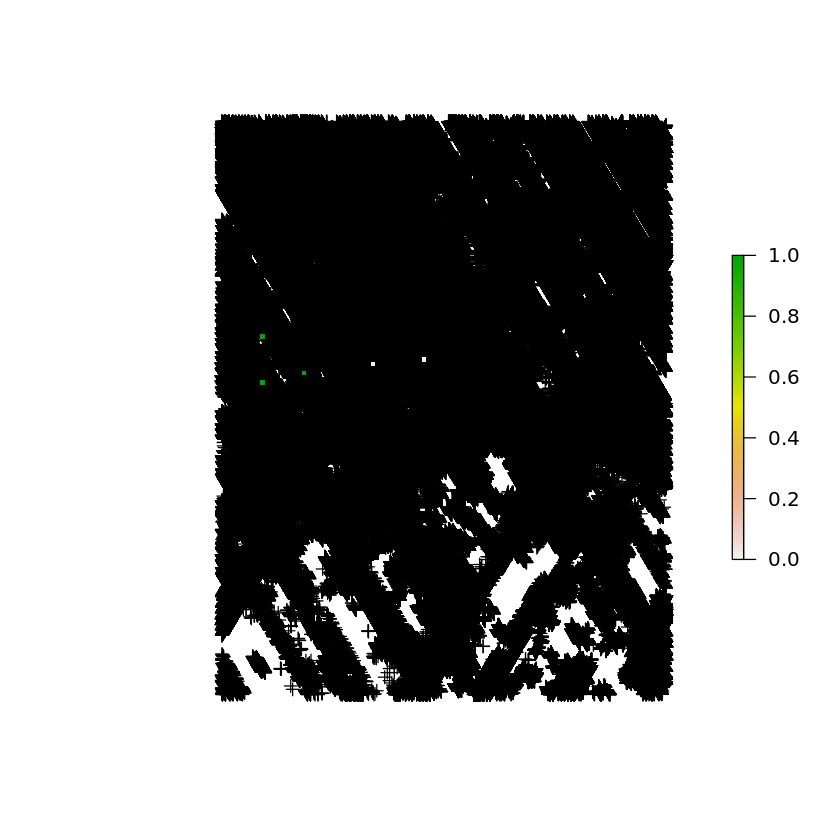

In [89]:
plot(gedi_l24_sp)
plot(mras$status,  add=TRUE)

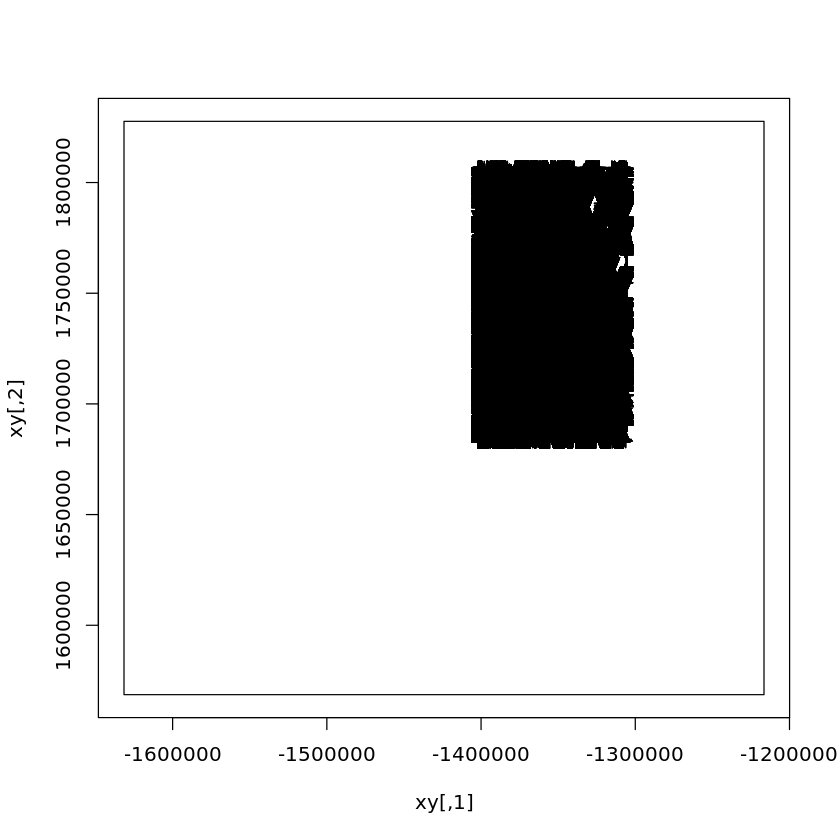

In [108]:
plot(extent(mras))
plot(gedi_l24_sp,  add=TRUE)

In [106]:
extent(gedi_l24_sp)

class      : Extent 
xmin       : -1401899 
xmax       : -1305413 
ymin       : 1682831 
ymax       : 1806811 

In [107]:
mras

class      : RasterStack 
dimensions : 259, 415, 107485, 7  (nrow, ncol, ncell, nlayers)
resolution : 1000, 1000  (x, y)
extent     : -1631530, -1216530, 1568650, 1827650  (xmin, xmax, ymin, ymax)
crs        : +proj=cea +lat_ts=30 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs 
names      : status,  pa_id, wwfbiom, wwfecoreg,    UID,    pft, region 
min values :      0, 352673,       1,         1,     29,      0,      0 
max values :      1, 352673,       1,         1,  64441,     11,      4 


In [69]:
matched_gedi%>%dim()


[1] 4042924       8

In [68]:
gedi_l24_sp%>%dim()

[1] 4042924      15

In [81]:
sub

[1] "SEN_pa_352642_matching_results_wk24.RDS"
[2] "SEN_pa_352673_matching_results_wk24.RDS"

In [112]:
list.files(path=f.path, pattern="L2A", all.files=TRUE, full.names=TRUE)[c(4,11)]

[1] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N12.30728831742391W-13.52951992770953.geojson_L2A.gpkg"
[2] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N13.30728831742391W-13.52951992770953.geojson_L2A.gpkg"

In [110]:
seq(length(all_gedil2_f))

[1] 1 2

In [114]:
all_gedil2_f 

[1] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N12.30728831742391W-12.52951992770953.geojson_L2A.gpkg"
[2] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N12.30728831742391W-13.52951992770953.geojson_L2A.gpkg"
[3] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles//N13.30728831742391W-13.52951992770953.geojson_L2A.gpkg"

In [121]:
seq(length(all_gedil2_f))

[1] 1 2

In [120]:
all_gedil2_f <- list.files(path=f.path, pattern="L2A", all.files=TRUE, full.names=TRUE)[c(4,11)]  
all_gedil4_f <- list.files(path=f.path, pattern="L4A", all.files=TRUE, full.names=TRUE)[c(4,11)]


In [126]:
mproc

[1] 1

In [16]:
extract_gedi <- function(matched, mras){
    f.path <- '~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/'
    
    all_gedil2_f <- list.files(path=f.path, pattern="L2A", all.files=TRUE, full.names=TRUE)[1:11]  
    all_gedil4_f <- list.files(path=f.path, pattern="L4A", all.files=TRUE, full.names=TRUE)[1:11] 
        
    registerDoParallel(cores=8)
    ex_out <- foreach(this_csvid=seq(length(all_gedil2_f)), 
                  .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
        ##add the GEDI l4a model prediction for AGB here :
        cat("Readng in no. ", this_csvid,"csv of ", length(all_gedil2_f),"csvs for iso3",iso3,"\n")

    for (this_gedi4 in all_gedil4_f[this_csvid]){
            gedil4_f <- as.data.frame(st_read(this_gedi4))}
    for (this_gedi2 in all_gedil2_f[this_csvid]){
            gedil2_f <- as.data.frame(st_read(this_gedi2))}
            if (nrow(gedil4_f) < 1){   #is.na(gedi_l4) || 
              cat("error")
              gedi_l24 <- gedil2_f
              gedi_l24$agbd <- NA
              gedi_l24$agbd_se <- NA
              gedi_l24$agbd_t <- NA
              gedi_l24$agbd_t_se <- NA
            } else {
              gedi_l4_sub <- gedil4_f %>%
                dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
              gedi_l24 <- inner_join(gedil2_f, gedi_l4_sub, by="shot_number")

            }

        print(dim(gedi_l24))
        iso_matched_gedi_df <- data.frame()
        if(nrow(gedi_l24)>0){
            gedi_l24_sp <- gedi_l24 %>% 
                SpatialPointsDataFrame(coords=.[,c("lon_lowestmode","lat_lowestmode")],
                                     proj4string=CRS("+init=epsg:4326"), data=.) %>%spTransform(., CRS("+init=epsg:6933"))

            matched_gedi <- raster::extract(mras,gedi_l24_sp, df=TRUE)
            matched_gedi_metrics <- cbind(matched_gedi,gedi_l24_sp@data)
            matched_gedi_metrics_filtered <- matched_gedi_metrics %>% dplyr::filter(!is.na(status)) %>% 
              convertFactor(matched0 = matched,exgedi = .) 

            iso_matched_gedi_df <- rbind(matched_gedi_metrics_filtered,iso_matched_gedi_df)
            print(dim(iso_matched_gedi_df))
        }

        return(iso_matched_gedi_df)
}
    
    stopImplicitCluster()
    cat("Done GEDI for no. ",grep(unique(matched$pa_id), matched_PAs),"pa out of", length(matched_PAs),"\n")
    return(ex_out)
    
}       

In [143]:
sub

[1] "SEN_pa_352642_matching_results_wk24.RDS"
[2] "SEN_pa_352673_matching_results_wk24.RDS"

In [9]:
source("~/GEDI_PA/matching_func-Copy1.r")

In [33]:
# SUB VERSION
mproc=2
registerDoParallel(cores=round(mproc))
getDoParWorkers()
startTime <- Sys.time()
foreach(this_rds=sub, .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {

    cat("Extracting for no. ", match(this_rds,sub),"pa out of", length(sub),"\n")
    if(nchar(iso3)>3){
        id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[4]  
    } else {
        id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[3]
    }
    print(id_pa)
    matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_results/SEN_wk24/",iso3,"_pa_",id_pa,"_matching_results_wk24.RDS", sep=""))
    if (is.null(matched)==TRUE  | nrow(matched)==0) {
        cat("Matched result is null for PA", id_pa, "quitting...\n")
    } else if (!is.null(matched)==TRUE){
    mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)}) #convert the macthed df to a raster stack 
    print(table(mras$status[]))
    if(table(mras$status[])[2]==0 | table(mras$status[])[1]==0 | is.null(mras)){
      cat("Rasterized results unbalanced for PA", id_pa, "quitting...\n")
    } else {
      startTime <- Sys.time()
      iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)#}  #run filtered csvs on mras for extarction

      tElapsed <- Sys.time()-startTime
      cat(tElapsed, "for extracting all PAs in", iso3,"\n")
      cat("Done GEDI for no. ",grep(unique(matched$pa_id), matched_PAs),"pa out of", length(matched_PAs),"\n")

      iso_matched_gedi <-  iso_matched_gedi %>%
#         #ASK AMBER ABOUT OG COLUMNS
#         #THIS NEEDS TO BE ADJUSTED!!!!
        dplyr::select("pa_id","status",
                      "wwfbiom","wwfecoreg","shot_number","lon_lowestmode", 
                      "lat_lowestmode", "lon_lowestmode", 
                      "lat_lowestmode","rh25", "rh50", "rh75","rh90", "rh98")  #write to individual country folder
      if (length(unique(iso_matched_gedi$wwfbiom)) >1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)%>% str_c( collapse = "+")
      } else if (length(unique(iso_matched_gedi$wwfbiom))==1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)
      } else {
        pabiome <- iso_matched_gedi$wwfbiom %>% unique()
      }
      # papaddd <- unique(iso_matched_gedi$PADDD) %>% getmode()
      continent <- unique(iso_matched_gedi$region) %>% getmode()
      print(paste('output df',dim(iso_matched_gedi)))

      dir.create(file.path(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/",iso3,"_wk",gediwk,"/",sep="")))
      saveRDS(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/",iso3,"_pa_", id_pa,"_gedi_wk_",gediwk,"_conti_","biome_",pabiome,".RDS", sep=""))
      cat(id_pa,"in",iso3,"results is written to dir\n")
      write.csv(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/","SEN_pa_", id_pa,"_iso_matched_gedi_sub_wk_",gediwk,".csv", sep=""))
    }
    
    }
    
    return(NULL)
}
stopImplicitCluster()
tElapsed <- Sys.time()-startTime
cat(tElapsed, "for extracting all PAs in", iso3,"\n")
cat("Done GEDI extraction for pa in ",iso3,"\n")    
    


[1] 2

NULL

3.691874 for extracting all PAs in SEN 
Done GEDI extraction for pa in  SEN 


In [17]:
library(progressr)


Attaching package: ‘progressr’


The following object is masked from ‘package:caret’:

    progress




In [ ]:
# MATCHED_PA VERSION

mproc=3
registerDoParallel(cores=round(mproc))
getDoParWorkers()
startTime <- Sys.time()

with_progress(
foreach(this_rds=matched_PAs, .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {

    cat("Extracting for no. ", match(this_rds,matched_PAs),"pa out of", length(matched_PAs),"\n")
    # flush.console()
    if(nchar(iso3)>3){
        id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[4]  
    } else {
        id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[3]
    }
    print(id_pa)
    matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_results/SEN_wk24/",iso3,"_pa_",id_pa,"_matching_results_wk24.RDS", sep=""))
    if (is.null(matched)==TRUE  | nrow(matched)==0) {
        cat("Matched result is null for PA", id_pa, "quitting...\n")
    } else if (!is.null(matched)==TRUE){
    mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)}) #convert the macthed df to a raster stack 
    print(table(mras$status[]))
    if(table(mras$status[])[2]==0 | table(mras$status[])[1]==0 | is.null(mras)){
      cat("Rasterized results unbalanced for PA", id_pa, "quitting...\n")
    } else {
      startTime <- Sys.time()
      iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)#}  #run filtered csvs on mras for extarction

      tElapsed <- Sys.time()-startTime
      cat(tElapsed, "for extracting all PAs in", iso3,"\n")
      cat("Done GEDI for no. ",grep(unique(matched$pa_id), matched_PAs),"pa out of", length(matched_PAs),"\n")

      iso_matched_gedi <-  iso_matched_gedi %>%
#         #ASK AMBER ABOUT OG COLUMNS
#         #THIS NEEDS TO BE ADJUSTED!!!!
        dplyr::select("pa_id","status",
                      "wwfbiom","wwfecoreg","shot_number","lon_lowestmode", 
                      "lat_lowestmode", "lon_lowestmode", 
                      "lat_lowestmode","rh25", "rh50", "rh75","rh90", "rh98")  #write to individual country folder
      if (length(unique(iso_matched_gedi$wwfbiom)) >1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)%>% str_c( collapse = "+")
      } else if (length(unique(iso_matched_gedi$wwfbiom))==1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)
      } else {
        pabiome <- iso_matched_gedi$wwfbiom %>% unique()
      }
      # papaddd <- unique(iso_matched_gedi$PADDD) %>% getmode()
      continent <- unique(iso_matched_gedi$region) %>% getmode()
      print(paste('output df',dim(iso_matched_gedi)))

      dir.create(file.path(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/",iso3,"_wk",gediwk,"/",sep="")))
      saveRDS(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/",iso3,"_pa_", id_pa,"_gedi_wk_",gediwk,"_conti_","biome_",pabiome,".RDS", sep=""))
      write.csv(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/","SEN_pa_", id_pa,"_iso_matched_gedi_sub_wk_",gediwk,".csv", sep=""))
      cat(id_pa,"in",iso3,"results is written to dir\n")
    }
    
    }

    return(NULL)
})


stopImplicitCluster()
tElapsed <- Sys.time()-startTime
cat(tElapsed, "for extracting all PAs in", iso3,"\n")
cat("Done GEDI extraction for pa in ",iso3,"\n")


[1] 3

In [45]:
length(list.files("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24",pattern = ".csv"))

[1] 60

#########not using the below anymore###########

In [34]:
fileA<-read.csv("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/SEN_pa_352673_iso_matched_gedi_sub_wk_24.csv")
dim(fileA)

[1] 20398    13

In [35]:
fileB<-read.csv("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/SEN_pa_352642_iso_matched_gedi_sub_wk_24.csv")
dim(fileB)

[1] 73248    13

In [141]:
########***not used***##########
#SUB VERSION UPDATING FOR ALL RDS
#Pull the CRS from one of the GEDI files so results use 
#Reprojection is clunky and needs to be updated, and overall the projections of above layers do not match the WGS84 projection
# tile<- st_read("~/shared-buckets/abarenblitt/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson")
#WORKS THROUGH MRAS
registerDoParallel(cores=round(mproc))
getDoParWorkers()
startTime <- Sys.time()

foreach(this_rds=sub, .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
  cat("Extracting for no. ", match(this_rds,sub),"pa out of", length(sub),"\n")
  if(nchar(iso3)>3){
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[4]  
  } else {
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[3]
  }
  matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_results/SEN_wk24/",iso3,"_pa_",id_pa,"_matching_results_wk24.RDS", sep=""))
  if (is.null(matched)==TRUE  | nrow(matched)==0) {
    cat("Matched result is null for PA", id_pa, "quitting...\n")
  } else if (!is.null(matched)==TRUE){
    mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)}) #convert the macthed df to a raster stack 
    if(table(mras$status[])[2]==0 | table(mras$status[])[1]==0 | is.null(mras)){
      cat("Rasterized results unbalanced for PA", id_pa, "quitting...\n")
    } else {
      startTime <- Sys.time()
      iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)#}  #run filtered csvs on mras for extarction
      tElapsed <- Sys.time()-startTime

      cat(tElapsed, "for extracting all PAs in", iso3,"\n")
      iso_matched_gedi_sub <- iso_matched_gedi %>%
#         #ASK AMBER ABOUT OG COLUMNS
#         #THIS NEEDS TO BE ADJUSTED!!!!
        dplyr::select("pa_id","status",
                      "wwfbiom","wwfecoreg","shot_number","lon_lowestmode", 
                      "lat_lowestmode", "lon_lowestmode", 
                      "lat_lowestmode","rh25", "rh50", "rh75","rh90", "rh98")  #write to individual country folder
      if (length(unique(iso_matched_gedi$wwfbiom)) >1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)%>% str_c( collapse = "+")
      } else if (length(unique(iso_matched_gedi$wwfbiom))==1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)
      } else {
        pabiome <- iso_matched_gedi$wwfbiom %>% unique()
      }
      # papaddd <- unique(iso_matched_gedi$PADDD) %>% getmode()
      continent <- unique(iso_matched_gedi$region) %>% getmode()

      dir.create(file.path(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/",iso3,"_wk",gediwk,"/",sep="")))
      saveRDS(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/",iso3,"_pa_", id_pa,"_gedi_wk_",gediwk,"_conti_","biome_",pabiome,".RDS", sep=""))
      cat(id_pa,"in",iso3,"results is written to dir\n")
      write.csv(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/","SEN_pa_", id_pa,"_iso_matched_gedi_sub_wk_",gediwk,".csv", sep=""))
    }
  }
  return(NULL)
}

stopImplicitCluster()
tElapsed <- Sys.time()-startTime
cat(tElapsed, "for extracting all PAs in", iso3,"\n")
cat("Done GEDI extraction for pa in ",iso3,"\n")    

[1] 1

Extracting for no.  1 pa out of 2 
SEN converting the matched csv to a raster stack for extraction
Done GEDI for no.  43 pa out of 107 
40.98683 for extracting all PAs in SEN 
352642 in SEN results is written to dir
Extracting for no.  2 pa out of 2 
SEN converting the matched csv to a raster stack for extraction
Done GEDI for no.  73 pa out of 107 
39.25359 for extracting all PAs in SEN 
352673 in SEN results is written to dir


NULL

1.515823 for extracting all PAs in SEN 
Done GEDI extraction for pa in  SEN 


In [12]:
#FULL VERSION UPDATING FOR ALL RDS
#Pull the CRS from one of the GEDI files so results use 
#Reprojection is clunky and needs to be updated, and overall the projections of above layers do not match the WGS84 projection
# tile<- st_read("~/shared-buckets/abarenblitt/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson")
#WORKS THROUGH MRAS
registerDoParallel(cores=round(mproc))
getDoParWorkers()
startTime <- Sys.time()

foreach(this_rds=matched_PAs, .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
  cat("Extracting for no. ", match(this_rds,matched_PAs),"pa out of", length(matched_PAs),"\n")
  if(nchar(iso3)>3){
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[4]  
  } else {
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[3]
  }
  matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_results/SEN_wk24/",iso3,"_pa_",id_pa,"_matching_results_wk24.RDS", sep=""))
  if (is.null(matched)==TRUE  | nrow(matched)==0) {
    cat("Matched result is null for PA", id_pa, "quitting...\n")
  } else if (!is.null(matched)==TRUE){
    mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)}) #convert the macthed df to a raster stack 
    if(table(mras$status[])[2]==0 | table(mras$status[])[1]==0 | is.null(mras)){
      cat("Rasterized results unbalanced for PA", id_pa, "quitting...\n")
    } else {
      startTime <- Sys.time()
      iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)#}  #run filtered csvs on mras for extarction
      tElapsed <- Sys.time()-startTime

      cat(tElapsed, "for extracting all PAs in", iso3,"\n")
      iso_matched_gedi_sub <- iso_matched_gedi %>%
#         #ASK AMBER ABOUT OG COLUMNS
#         #THIS NEEDS TO BE ADJUSTED!!!!
        dplyr::select("pa_id","status",
                      "wwfbiom","wwfecoreg","shot_number","lon_lowestmode", 
                      "lat_lowestmode", "lon_lowestmode", 
                      "lat_lowestmode","rh25", "rh50", "rh75","rh90", "rh98")  #write to individual country folder
      if (length(unique(iso_matched_gedi$wwfbiom)) >1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)%>% str_c( collapse = "+")
      } else if (length(unique(iso_matched_gedi$wwfbiom))==1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)
      } else {
        pabiome <- iso_matched_gedi$wwfbiom %>% unique()
      }
      # papaddd <- unique(iso_matched_gedi$PADDD) %>% getmode()
      continent <- unique(iso_matched_gedi$region) %>% getmode()

      dir.create(file.path(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/",iso3,"_wk",gediwk,"/",sep="")))
      saveRDS(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/",iso3,"_pa_", id_pa,"_gedi_wk_",gediwk,"_conti_","biome_",pabiome,".RDS", sep=""))
      cat(id_pa,"in",iso3,"results is written to dir\n")
      write.csv(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/","SEN_pa_", id_pa,"_iso_matched_gedi_sub_wk_",gediwk,".csv", sep=""))
    }
  }
  return(NULL)
}

stopImplicitCluster()
tElapsed <- Sys.time()-startTime
cat(tElapsed, "for extracting all PAs in", iso3,"\n")
cat("Done GEDI extraction for pa in ",iso3,"\n")    

[1] 1

In [11]:
matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_results/SEN_wk24/SEN_pa_2332_matching_results_wk24.RDS", sep=""))

In [12]:
 mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)}) #convert the macthed df to a raster stack 


SEN converting the matched csv to a raster stack for extraction


In [ ]:
id_pa<-2332
matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_results/SEN_wk24/SEN_pa_2332_matching_results_wk24.RDS", sep=""))
  if (is.null(matched)==TRUE  | nrow(matched)==0) {
    cat("Matched result is null for PA", id_pa, "quitting...\n")
  } 

# else if (!is.null(matched)==TRUE){
    mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)}) #convert the macthed df to a raster stack 
    # if(table(mras$status[])[2]==0 | table(mras$status[])[1]==0 | is.null(mras)){
    #   cat("Rasterized results unbalanced for PA", id_pa, "quitting...\n")
    # } else {
    #   startTime <- Sys.time()
      iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)  #run filtered csvs on mras for extarction
      # tElapsed <- Sys.time()-startTime

      # cat(tElapsed, "for extracting all PAs in", iso3,"\n")
      iso_matched_gedi_sub <- iso_matched_gedi %>%
        #ASK AMBER ABOUT OG COLUMNS
        #THIS NEEDS TO BE ADJUSTED!!!!
        dplyr::select("pa_id","status",
                      "wwfbiom","wwfecoreg","shot_number","lon_lowestmode", 
                      "lat_lowestmode", "lon_lowestmode", 
                      "lat_lowestmode","rh25", "rh50", "rh75","rh90", "rh98")  #write to individual country folder
      # if (length(unique(iso_matched_gedi$wwfbiom)) >1){
      #   pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)%>% str_c( collapse = "+")
      # } else if (length(unique(iso_matched_gedi$wwfbiom))==1){
      #   pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)
      # } else {
      #   pabiome <- iso_matched_gedi$wwfbiom %>% unique()
      # }
      # # papaddd <- unique(iso_matched_gedi$PADDD) %>% getmode()
      # continent <- unique(iso_matched_gedi$region) %>% getmode()

    #   dir.create(file.path(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/",iso3,"_wk",gediwk,"/",sep="")))
    #   saveRDS(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/",iso3,"_pa_", id_pa,"_gedi_wk_",gediwk,"_conti_","biome_",pabiome,".RDS", sep=""))
    #   cat(id_pa,"in",iso3,"results is written to dir\n")
    #   write.csv(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/","SEN_pa_", id_pa,"_iso_matched_gedi_sub_wk_",gediwk,".csv", sep=""))
    # }

In [43]:
#---------------STEP6: [FIGURE 4B] Calculating per pa summary stats, 1 pa per row, contain shot#/PA---------------------------- 
f.path<-"~/GEDI_PA/Matching_Layers/SEN/"
gedi_paf <-list.files(paste(f.path,"WDPA_GEDI_extract4/",iso3,"_wk",gediwk,sep=""), pattern=".RDS", full.names = TRUE)
cat(paste("Step 6: calculating per pa summary stats for", iso3,"\n"))
# if (file.exists(paste(f.path,"WDPA_GEDI_extract3/pa_stats/",iso3,"_pa_stats_summary_wk",gediwk,".csv", sep=""))) {
#   #Delete existing files in exists to avoid duplicate appending
#   cat("old version for", iso3,"exists, removing...\n")
#   file.remove(paste(f.path,"WDPA_GEDI_extract3/pa_stats/",iso3,"_pa_stats_summary_wk",gediwk,".csv", sep=""))
# }

Step 6: calculating per pa summary stats for SEN 


In [45]:
pa_metrics <-readRDS(gedi_paf[3])

ERROR: Error in gzfile(file, "rb"): invalid 'description' argument


In [113]:
length(table(pa_metrics$status))

[1] 0

In [ ]:
if (flag =="run all"){
  if(file.exists(paste(f.path,"WDPA_GEDI_extract4/pa_stats/",iso3,"_pa_stats_summary_wk",gediwk,".csv", sep=""))){  #if flag indicates running all steps, we remove the pa_stats for the iso from previous iteration and prompt creation of a new file
    file.remove(paste(f.path,"WDPA_GEDI_extract4/pa_stats/",iso3,"_pa_stats_summary_wk",gediwk,".csv", sep=""))
  }
  
  for (this_paf in gedi_paf){
    cat(this_paf,"\n")
    pa_metrics <-readRDS(this_paf)
    if (length(table(pa_metrics$status))<2) {
      cat(iso3, this_paf, "has 0 protected or treatment \n")
    } else if (table(pa_metrics$status)[1]!=0 && table(pa_metrics$status)[2]!=0) {
      #filter the datafrme by number of shots in each cell, which is euivalent of the number of occurence of each unique UID code
      tt <- table(pa_metrics$UID)
      qcellid <- table(pa_metrics$UID)[tt>5] %>% names()
      pa_metrics_filtered <- pa_metrics %>% dplyr::filter(UID %in% qcellid)
      
      #calc summary stats for each country 
      if(nrow(pa_metrics_filtered)>0){
        pa_stats_summary <- pa_metrics_filtered %>%
          group_by(status) %>% 
          dplyr::mutate(pa_id=as.character(pa_id)) %>%
          dplyr::summarise(pa_id=na.omit(unique(pa_id)),
                           count=length(rh98),meanrh98=mean(rh98, na.rm=TRUE), sdrh98=sd(rh98, na.rm = TRUE),medrh98=median(rh98, na.rm = TRUE),
                           meanrh75=mean(rh75,na.rm=TRUE), sdrh75=sd(rh75,na.rm=TRUE), medrh75=median(rh75,na.rm=TRUE),
                           meanrh50=mean(rh50,na.rm=TRUE), sdrh50=sd(rh50,na.rm=TRUE), medrh50=median(rh50,na.rm=TRUE),
                           meanrh25=mean(rh25,na.rm=TRUE ), sdrh25=sd(rh25, na.rm=TRUE),medrh25=median(rh25, na.rm=TRUE),
                           # meanpai=mean(pai, na.rm=TRUE), sdpai=sd(pai, na.rm=TRUE), medpai=median(pai, na.rm=TRUE),
                           # meancov=mean(cover, na.rm=TRUE), sdcov=sd(cover,na.rm=TRUE),  medcov=median(cover,na.rm=TRUE),
                           meanagbd=mean(agbd, na.rm=TRUE), sdagbd=sd(agbd, na.rm=TRUE),medagbd=median(agbd, na.rm=TRUE),
                           wwfecoreg=getmode(wwfecoreg),REGION=getmode(region))%>% 
          tidyr::pivot_wider(names_from=status, values_from= setdiff(names(.),c("pa_id", "status"))) #writeLine to a large txt file where world pas stats are
        pa_stats_summary$iso3 <- iso3
        print(ncol(pa_stats_summary))
        if(ncol(pa_stats_summary)>30){
          if(!file.exists(paste(f.path,"WDPA_GEDI_extract4/pa_stats/",iso3,"_pa_stats_summary_wk",gediwk,".csv", sep=""))){
            print("not exists")
            write.csv(pa_stats_summary, file=paste(f.path,"WDPA_GEDI_extract4/pa_stats/",iso3,"_pa_stats_summary_wk",gediwk,".csv", sep=""), row.names = FALSE)
          } else if (file.exists(paste(f.path,"WDPA_GEDI_extract4/pa_stats/",iso3,"_pa_stats_summary_wk",gediwk,".csv", sep=""))){
            print("exists so appending to existing file")
            write.table(pa_stats_summary, file=paste(f.path,"WDPA_GEDI_extract4/pa_stats/",iso3,"_pa_stats_summary_wk",gediwk,".csv", sep=""),
                        sep=",", append=TRUE , row.names=FALSE, col.names=FALSE)   #will not overwrite but append to existing files
          }
          
        }
      }
    }
  }
  cat("Done summarizing pa-level stats for country",iso3,"\n")  
}

ERROR: Error in eval(expr, envir, enclos): object 'gedi_paf' not found


In [48]:
#---------------STEP7: [Figure 4A] Removing dup gedi shots in overlapping region, count shot#/PA w/o dups, results in [extract4/iso_full_nodup]-------------------
f.path<-"~/GEDI_PA/Matching_Layers/SEN/"
gedi_paf <-list.files(paste(f.path,"WDPA_GEDI_extract4/",iso3,"_wk",gediwk,sep=""), pattern=".RDS", full.names = TRUE)
fullds <- data.frame()
cat ("Step7a: Compiling country wide dataframe for",iso3, "and removing duplicates...\n")

gedi_paf
for (c in gedi_paf){  #removing dups based on shot#
  cat(match(c, gedi_paf),"in total of", length(gedi_paf),"files\n")
  tmpds <- tryCatch(readRDS(c),error=function(cond){return(NULL)})
  if(!is.null(tmpds)){
    tmpds$shot_number=as.character(tmpds$shot_number)
    tt <- table(tmpds$UID)
    qcellid <- table(tmpds$UID)[tt>5] %>% names()
    tmpds_filtered <- tmpds %>% dplyr::filter(UID %in% qcellid)
    fullds <- rbind(fullds, tmpds_filtered)
    print(dim(fullds))
    fullds <- fullds[!duplicated(fullds$shot_number), ]
    print(dim(fullds))
  } else {
    fullds <- fullds
    print(dim(fullds))
    
  }
  
}
fullds$iso3 <- iso3
write.csv(fullds, file=paste(f.path,"WDPA_GEDI_extract4/iso_full_nodup/",iso3,"_country_full_nodup_wk",gediwk,".csv", sep=""), row.names = F)
cat(iso3,"Dup removed df is exported to /iso_full_nodup/ \n")

Step7a: Compiling country wide dataframe for SEN and removing duplicates...


character(0)

ERROR: Error in `$<-.data.frame`(`*tmp*`, iso3, value = "SEN"): replacement has 1 row, data has 0


In [16]:
#---------------STEP7b: Rasterize the non-dup GEDI results to return the shots-per-1km results, results in [extract4/cell_stats/] & [extract4/matched_raster_stack]---------------------------------
cat("Step 7b: Summarizing #of GEDI shots per 1km pixel\n ")
# fullds0 <- read.csv(paste(f.path,"WDPA_GEDI_extract3/iso_full_nodup/",iso3,"_country_full_nodup_wk",gediwk,".csv", sep=""))
iso_gedi_spdf <- SpatialPointsDataFrame(coords=fullds[,c("lon_lowestmode","lat_lowestmode")],
                                                proj4string=CRS("+init=epsg:4326"), data=fullds) %>%spTransform(., CRS("+init=epsg:6933"))
ras <- crop(MCD12Q1, extent(iso_gedi_spdf)) #a little slow with buffer 
gcount_ras <- rasterize(coordinates(iso_gedi_spdf),ras, fun="count",background=NA)
names(gcount_ras) <- "gshot_counts"
gpid_ras <- rasterize(coordinates(iso_gedi_spdf),ras, fun=getmode,field=iso_gedi_spdf$pa_id,background=NA)
names(gpid_ras) <- "pid"
gattr_ras <- rasterize(iso_gedi_spdf@coords, ras, fun=getmode, field=iso_gedi_spdf$status, background=NA)
names(gattr_ras) <- "status"
gstack <- stack(gcount_ras,gpid_ras,gattr_ras)
g1km_sp <- as(gstack, 'SpatialPointsDataFrame')
g1km <- cbind(g1km_sp@coords, g1km_sp@data, country=iso3)
# dir.create(paste(f.path,"WDPA_GEDI_extract3/cell_stats/",sep=""))
# writeRaster(gstack,paste(f.path,"WDPA_GEDI_extract4/matched_raster_stack/",iso3,"_cell_shots_pa_wk",gediwk,".tif", sep=""))  #just for later checks as needed
write.csv(g1km, file=paste(f.path,"WDPA_GEDI_extract4/cell_stats/",iso3,"_cell_shots_wk",gediwk,".csv", sep=""))
cat(iso3,"1km pixel level shot count df is exported to /cell_stats/ \n")
rm(ras, gstack)

Step 7b: Summarizing #of GEDI shots per 1km pixel
 SEN 1km pixel level shot count df is exported to /cell_stats/ 


In [18]:
#---------------STEP8: Calculating per country summary stats, 1 country per row, summarize key stats for the country ---------------------    
cat("Step 8: Calculating country level summary stats for ", iso3,"\n ")
# fullds <- read.csv(paste(f.path,"WDPA_GEDI_extract3/iso_full_nodup/",iso3,"_country_full_nodup_wk",gediwk,".csv", sep=""))
getmode <- function(v) {
  uniqv <- na.omit(unique(v))
  uniqv[which.max(tabulate(match(v, uniqv)))]
}

# fullds <- read.csv(paste(f.path,"WDPA_GEDI_extract4/iso_full_nodup/",iso3,"_country_full_nodup_wk",gediwk,".csv", sep=""))

#Currently commented out since L2B needed
# fullds$pai[!is.finite(fullds$pai)] <- NA

iso_sum <- fullds %>%
  group_by(status) %>%  
  dplyr::summarise(count_ttl=length(rh98),
                   meanrh98=mean(rh98, na.rm=TRUE), sdrh98=sd(rh98, na.rm = TRUE), medrh98=median(rh98, na.rm = TRUE),msrh98=sum(is.na(rh98)),
                   # meanpai=mean(pai, na.rm=TRUE), sdpai=sd(pai, na.rm=TRUE),  medpai=median(pai, na.rm=TRUE),mspai=sum(is.na(pai)),
                   # meancov=mean(cover, na.rm=TRUE), sdcov=sd(cover,na.rm=TRUE),  medcov=median(cover,na.rm=TRUE),mscov=sum(is.na(cov)),
                   meanagbd=mean(agbd, na.rm=TRUE), sdagbd=sd(agbd, na.rm=TRUE), medagbd=median(agbd, na.rm=TRUE), msagbd=sum(is.na(agbd)))%>% 
  tidyr::pivot_wider(names_from=status, values_from= setdiff(names(.),c("pa_id", "status")))#writeLine to a large txt file where world pas stats are
iso_sum$iso3 <- iso3
continent <- fullds$region %>% unique() %>% getmode()
iso_sum$continent <- continent

write.csv(iso_sum, file=paste(f.path,"WDPA_GEDI_extract4/iso_stats/",iso3,"_country_stats_summary_wk",gediwk,"2.csv", sep=""), row.names = F)
cat(iso3,"country level summary stats is exported to /iso_stats/ \n")


Step 8: Calculating country level summary stats for  SEN 
 SEN country level summary stats is exported to /iso_stats/ 


In [30]:
id_pa <-2333
matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/SEN_wk24/",iso3,"_pa_", id_pa,"_matching_results_wk",gediwk,".RDS", sep=""))

In [129]:
mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)})

SEN converting the matched csv to a raster stack for extraction


In [167]:
f.path <- '~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/'
all_gedil2_f <- list.files(path=f.path, pattern="L2A", all.files=FALSE, full.names=FALSE)
length(all_gedil2_f)

[1] 47

In [147]:
table <- as.data.frame(gedi)
print(table)

                                                    gedi
1 N12.30728831742391W-11.52951992770953.geojson_L2A.gpkg


In [157]:
extract_gedi <- function(matched, mras){
    f.path <- '~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/'
    
    all_gedil2_f <- list.files(path=f.path, pattern="L2A", all.files=FALSE, full.names=FALSE)  
    all_gedil4_f <- list.files(path=f.path, pattern="L4A", all.files=FALSE, full.names=FALSE)  
        
    registerDoParallel(cores=1)
    ex_out <- foreach(this_csvid=seq(length(all_gedil2_f)), 
                  .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
        ##add the GEDI l4a model prediction for AGB here :
        cat("Readng in no. ", this_csvid,"csv of ", length(all_gedil2_f),"csvs for iso3",iso3,"\n")

    for (this_gedi4 in all_gedil4_f){
        gedil4_f <- st_read(this_gedi4)}
    for (this_gedi2 in all_gedil2_f){
        gedil2_f <- st_read(this_gedi2)}
            if (nrow(gedil4_f) < 1){   #is.na(gedi_l4) || 
              cat("error")
              gedi_l24 <- gedil2_f
              gedi_l24$agbd <- NA
              gedi_l24$agbd_se <- NA
              gedi_l24$agbd_t <- NA
              gedi_l24$agbd_t_se <- NA
            } else {
              gedi_l4_sub <- gedil4_f %>%
                dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
              gedi_l24 <- inner_join(gedil2_f, gedi_l4_sub, by="shot_number")

            }

        print(dim(gedi_l24))
        iso_matched_gedi_df <- data.frame()
        if(nrow(gedi_l24)>0){
            gedi_l24_sp <- gedi_l24 %>% 
                SpatialPointsDataFrame(coords=.[,c("lon_lowestmode","lat_lowestmode")],
                                     proj4string=CRS("+init=epsg:4326"), data=.) %>%spTransform(., CRS("+init=epsg:6933"))

            matched_gedi <- raster::extract(mras,gedi_l24_sp, df=TRUE)
            matched_gedi_metrics <- cbind(matched_gedi,gedi_l24_sp@data)
            matched_gedi_metrics_filtered <- matched_gedi_metrics %>% dplyr::filter(!is.na(status)) %>% 
              convertFactor(matched0 = matched,exgedi = .) 

            iso_matched_gedi_df <- rbind(matched_gedi_metrics_filtered,iso_matched_gedi_df)
            print(dim(iso_matched_gedi_df))
        }

        return(iso_matched_gedi_df)
}
    
    stopImplicitCluster()
    cat("Done GEDI for no. ",grep(unique(matched$pa_id), matched_PAs),"pa out of", length(matched_PAs),"\n")
    return(ex_out)
    
} 

In [158]:
extract_gedi(matched, mras)

Readng in no.  1 csv of  47 csvs for iso3 SEN 
Readng in no.  2 csv of  47 csvs for iso3 SEN 
Readng in no.  3 csv of  47 csvs for iso3 SEN 
Readng in no.  4 csv of  47 csvs for iso3 SEN 
Readng in no.  5 csv of  47 csvs for iso3 SEN 
Readng in no.  6 csv of  47 csvs for iso3 SEN 
Readng in no.  7 csv of  47 csvs for iso3 SEN 
Readng in no.  8 csv of  47 csvs for iso3 SEN 
Readng in no.  9 csv of  47 csvs for iso3 SEN 
Readng in no.  10 csv of  47 csvs for iso3 SEN 
Readng in no.  11 csv of  47 csvs for iso3 SEN 
Readng in no.  12 csv of  47 csvs for iso3 SEN 
Readng in no.  13 csv of  47 csvs for iso3 SEN 
Readng in no.  14 csv of  47 csvs for iso3 SEN 
Readng in no.  15 csv of  47 csvs for iso3 SEN 
Readng in no.  16 csv of  47 csvs for iso3 SEN 
Readng in no.  17 csv of  47 csvs for iso3 SEN 
Readng in no.  18 csv of  47 csvs for iso3 SEN 
Readng in no.  19 csv of  47 csvs for iso3 SEN 
Readng in no.  20 csv of  47 csvs for iso3 SEN 
Readng in no.  21 csv of  47 csvs for iso3 SEN 
R

ERROR: Error in {: task 1 failed - "Cannot open "N12.30728831742391W-10.52951992770953.geojson_L4A.gpkg"; The file doesn't seem to exist."


In [155]:
f.path <- '~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/'
all_gedil2_f <- list.files(path=f.path, pattern="L2A", all.files=FALSE, 
    full.names=FALSE) 

In [156]:
all_gedil2_f

[1] "N12.30728831742391W-11.52951992770953.geojson_L2A.gpkg"
 [2] "N12.30728831742391W-12.52951992770953.geojson_L2A.gpkg"
 [3] "N12.30728831742391W-13.52951992770953.geojson_L2A.gpkg"
 [4] "N12.30728831742391W-14.52951992770953.geojson_L2A.gpkg"
 [5] "N12.30728831742391W-15.52951992770953.geojson_L2A.gpkg"
 [6] "N12.30728831742391W-16.52951992770953.geojson_L2A.gpkg"
 [7] "N12.30728831742391W-17.52951992770953.geojson_L2A.gpkg"
 [8] "N13.30728831742391W-10.52951992770953.geojson_L2A.gpkg"
 [9] "N13.30728831742391W-11.52951992770953.geojson_L2A.gpkg"
[10] "N13.30728831742391W-12.52951992770953.geojson_L2A.gpkg"
[11] "N13.30728831742391W-13.52951992770953.geojson_L2A.gpkg"
[12] "N13.30728831742391W-14.52951992770953.geojson_L2A.gpkg"
[13] "N13.30728831742391W-15.52951992770953.geojson_L2A.gpkg"
[14] "N13.30728831742391W-16.52951992770953.geojson_L2A.gpkg"
[15] "N13.30728831742391W-17.52951992770953.geojson_L2A.gpkg"
[16] "N14.30728831742391W-10.52951992770953.geojson_L2A.gpkg"
[17] "N14.30728831742391W-11.52951992770953.geojson_L2A.gpkg"
[18] "N14.30728831742391W-12.52951992770953.geojson_L2A.gpkg"
[19] "N14.30728831742391W-13.52951992770953.geojson_L2A.gpkg"
[20] "N14.30728831742391W-14.52951992770953.geojson_L2A.gpkg"
[21] "N14.30728831742391W-15.52951992770953.geojson_L2A.gpkg"
[22] "N14.30728831742391W-16.52951992770953.geojson_L2A.gpkg"
[23] "N14.30728831742391W-17.52951992770953.geojson_L2A.gpkg"
[24] "N15.30728831742391W-10.52951992770953.geojson_L2A.gpkg"
[25] "N15.30728831742391W-11.52951992770953.geojson_L2A.gpkg"
[26] "N15.30728831742391W-12.52951992770953.geojson_L2A.gpkg"
[27] "N15.30728831742391W-13.52951992770953.geojson_L2A.gpkg"
[28] "N15.30728831742391W-14.52951992770953.geojson_L2A.gpkg"
[29] "N15.30728831742391W-15.52951992770953.geojson_L2A.gpkg"
[30] "N15.30728831742391W-16.52951992770953.geojson_L2A.gpkg"
[31] "N15.30728831742391W-17.52951992770953.geojson_L2A.gpkg"
[32] "N16.30728831742391W-10.52951992770953.geojson_L2A.gpkg"
[33] "N16.30728831742391W-11.52951992770953.geojson_L2A.gpkg"
[34] "N16.30728831742391W-12.52951992770953.geojson_L2A.gpkg"
[35] "N16.30728831742391W-13.52951992770953.geojson_L2A.gpkg"
[36] "N16.30728831742391W-14.52951992770953.geojson_L2A.gpkg"
[37] "N16.30728831742391W-15.52951992770953.geojson_L2A.gpkg"
[38] "N16.30728831742391W-16.52951992770953.geojson_L2A.gpkg"
[39] "N16.30728831742391W-17.52951992770953.geojson_L2A.gpkg"
[40] "N17.30728831742391W-10.52951992770953.geojson_L2A.gpkg"
[41] "N17.30728831742391W-11.52951992770953.geojson_L2A.gpkg"
[42] "N17.30728831742391W-12.52951992770953.geojson_L2A.gpkg"
[43] "N17.30728831742391W-13.52951992770953.geojson_L2A.gpkg"
[44] "N17.30728831742391W-14.52951992770953.geojson_L2A.gpkg"
[45] "N17.30728831742391W-15.52951992770953.geojson_L2A.gpkg"
[46] "N17.30728831742391W-16.52951992770953.geojson_L2A.gpkg"
[47] "N17.30728831742391W-17.52951992770953.geojson_L2A.gpkg"

In [94]:

all_gedil2_f 

character(0)